# Image Classification Task

## Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import torch
import torchvision.transforms as T
import torch.nn as nn
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
from torch.utils.data import random_split
from torchvision.utils import make_grid
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix

## Importing Dataset

With these pieces of code, we are importing our dataset from our own drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/archive.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: dataset/43857 beam 1x2 300R.png  
  inflating: dataset/43857 beam 1x2 301L.png  
  inflating: dataset/43857 beam 1x2 301R.png  
  inflating: dataset/43857 beam 1x2 302L.png  
  inflating: dataset/43857 beam 1x2 302R.png  
  inflating: dataset/43857 beam 1x2 303L.png  
  inflating: dataset/43857 beam 1x2 303R.png  
  inflating: dataset/43857 beam 1x2 304L.png  
  inflating: dataset/43857 beam 1x2 304R.png  
  inflating: dataset/43857 beam 1x2 305L.png  
  inflating: dataset/43857 beam 1x2 305R.png  
  inflating: dataset/43857 beam 1x2 306L.png  
  inflating: dataset/43857 beam 1x2 306R.png  
  inflating: dataset/43857 beam 1x2 307L.png  
  inflating: dataset/43857 beam 1x2 307R.png  
  inflating: dataset/43857 beam 1x2 308L.png  
  inflating: dataset/43857 beam 1x2 308R.png  
  inflating: dataset/43857 beam 1x2 309L.png  
  inflating: dataset/43857 beam 1x2 309R.png  
  inflating: dataset/43857 beam 1x2 310L.png  
  inflatin

In [128]:
dest_dir= "/content/LEGO brick images v1"

In [129]:
classes = os.listdir(dest_dir)

In [130]:
print(classes)

['3069 Flat Tile 1x2', '3794 Plate 1X2 with 1 Knob', '3022 Plate 2x2', '3713 Bush for Cross Axle', '3024 Plate 1x1', '3673 Peg 2M', '3004 Brick 1x2', '3003 Brick 2x2', '3040 Roof Tile 1x2x45deg', '6632 Technic Lever 3M', '2357 Brick corner 1x2x2', '3005 Brick 1x1', '3023 Plate 1x2', '11214 Bush 3M friction with Cross axle', '32123 half Bush', '18651 Cross Axle 2M with Snap friction']


In [131]:
sizedf = {}

for category in classes:
  sizedf[category] = len(os.listdir(dest_dir + '/' + category))

In [132]:
sizedf

{'11214 Bush 3M friction with Cross axle': 400,
 '18651 Cross Axle 2M with Snap friction': 400,
 '2357 Brick corner 1x2x2': 379,
 '3003 Brick 2x2': 400,
 '3004 Brick 1x2': 400,
 '3005 Brick 1x1': 400,
 '3022 Plate 2x2': 400,
 '3023 Plate 1x2': 400,
 '3024 Plate 1x1': 400,
 '3040 Roof Tile 1x2x45deg': 400,
 '3069 Flat Tile 1x2': 400,
 '32123 half Bush': 400,
 '3673 Peg 2M': 400,
 '3713 Bush for Cross Axle': 400,
 '3794 Plate 1X2 with 1 Knob': 400,
 '6632 Technic Lever 3M': 400}

In [133]:
class LegoDataset(Dataset):
  def __init__(self, dset_dir, transforms=T.Compose([])):
    self.dset_dir = Path(dset_dir)
    self.transforms = transforms
    self.files = []

    folders = sorted(os.listdir(self.dset_dir))
    for folder in folders:
      class_idx = folders.index(folder)
      folder_dir = self.dset_dir/folder
      files = os.listdir(folder_dir)
      self.files += [{"file": folder_dir/x, "class": class_idx} for x in files]

  def __len__(self):
    return len(self.files)

  def __getitem__(self, i):
    item = self.files[i]
    file = item['file']
    class_idx = torch.tensor(item['class'])

    img = Image.open(file).convert("RGB")
    img = self.transforms(img)
    return img, class_idx

In [134]:
transforms = T.Compose([
        T.Resize(32),
        T.ToTensor(),
        T.Normalize(0.5, 0.5)
    ])

In [135]:
dset = LegoDataset(dest_dir, transforms=transforms)

In [136]:
print(len(dset))

6379


Our dataset contains 6379 images of 16 classes.

## Splitting

Now we are going to split our data into train, validation and test set.

In [137]:
val_size = len(dset)//10
test_size = len(dset)//5
train_size = len(dset) - val_size -test_size
train_dset, val_dset, test_dset = random_split(dset, [train_size, val_size, test_size])
len(train_dset), len(val_dset),len(test_dset)

(4467, 637, 1275)

In [138]:
data, label = train_dset[0]
print(data.shape)

torch.Size([3, 32, 32])


In [139]:
train_loader = DataLoader(train_dset, batch_size=32, shuffle=True, drop_last=True, num_workers=2)
test_loader = DataLoader(test_dset, batch_size=32, shuffle=False, drop_last=False, num_workers=2)
val_loader = DataLoader(val_dset, batch_size=32, shuffle=False, drop_last=False, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


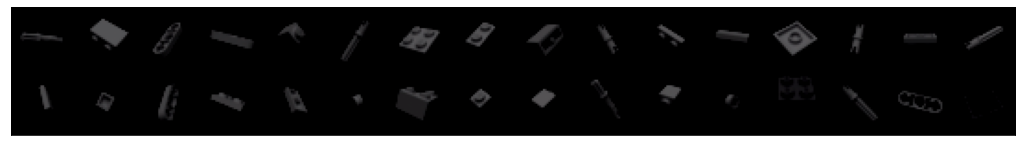

In [140]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [141]:
inputs, labels = next(iter(train_loader))
print(inputs.shape)
print(labels.shape)

torch.Size([32, 3, 32, 32])
torch.Size([32])


## Creating our CNN

The minimal layers we need for defining a CNN are:



*   Convolutional layer:

  `nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation)`

*   Non-linear layer:

  `nn.ReLU()`

*   Max pooling:

  `nn.MaxPool2d(kernel_size, stride)`



### 5 layers

First, we are going to define only the 5 layers in order to find the output that will be the input of the dense layer.

In [142]:
class FirstCNN(nn.Module):

  #Constructor
  def __init__(self, in_size=3, out_size=16, use_norm=False):
    # Call parent contructor
    super().__init__()
    self.layers = nn.Sequential(
      # Layer 1
      nn.Conv2d(in_channels=in_size, out_channels=8, kernel_size=3, padding=0, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(8),
      # Layer 2
      nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(16),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 3
      nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(32),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 4
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(64),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 5
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(128),
      nn.AdaptiveMaxPool2d(output_size=2)
    )

  # Forward
  def forward(self, x):
    output = self.layers(x)
    return output

In [143]:
net = FirstCNN()
# Get an element from the dataset

Now we are assigning an image to a variable in order to test the model and find the output size.

In [144]:
test_x, _ = train_dset[0] # each element of the dataset is a couple (image, label)

In [145]:
test_x.size()

torch.Size([3, 32, 32])

In [146]:
test_x = test_x.unsqueeze(dim=0)
test_x.size()

torch.Size([1, 3, 32, 32])

In [147]:
output = net(test_x)
output.shape

torch.Size([1, 128, 2, 2])

In [148]:
out_features = output.size(1)*output.size(2)*output.size(3)
print(out_features)

512


Our output size is 512.

In [149]:
class FirstCNN(nn.Module):

  #Constructor
  def __init__(self, in_size=3, out_size=16, use_norm=False):
    # Call parent contructor
    super().__init__()
    self.layers = nn.Sequential(
      # Layer 1
      nn.Conv2d(in_channels=in_size, out_channels=8, kernel_size=3, padding=0, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(8),
      # Layer 2
      nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(16),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 3
      nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(32),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 4
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(64),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 5
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(128),
      nn.AdaptiveMaxPool2d(output_size=2)
    )
    self.fc_layers = nn.Sequential(
        nn.Linear(512, 1024), 
        nn.ReLU(),
        nn.Linear(1024, 16)
    )
  # Forward
  def forward(self, x):
    x = self.layers(x)
    x = x.view(x.size(0), -1)
    output = self.fc_layers(x)
    return output

Now we are going to define the training algorithm.

In [150]:
def train(net, loaders, optimizer, criterion, epochs=100, device=torch.device('cpu')):
    try:
        net = net.to(device)
        print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        results = [0,0,0]
        valiloss = None
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                if split == "train":
                  net.train()
                else:
                  net.eval()
                # Process each batch
                for (input, labels) in tqdm(loaders[split],desc=split):
                    # Move to CUDA
                    input = input.to(device)
                    labels = labels.to(device)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(input)
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    _,pred_labels = pred.max(1)
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},")
            if valiloss is None or epoch_loss['val'] < valiloss:
              valiloss = epoch_loss['val']
              results = [epoch_accuracy['train'], epoch_accuracy['val'], epoch_accuracy['test']]  

    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()
        return results

Before training, we would like to know if the GPU is available. If not, we are going to use CPU, but it's preferrable to use cuda, because it improves performances in a huge way.

In [151]:
torch.cuda.is_available()

True

FirstCNN(
  (layers): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15):

train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1: TrL=1.7322, TrA=0.4870, VL=1.0881, VA=0.7133, TeL=1.1151, TeA=0.6735,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2: TrL=0.8811, TrA=0.7253, VL=0.7558, VA=0.7267, TeL=0.7687, TeA=0.7187,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3: TrL=0.6149, TrA=0.7995, VL=0.5465, VA=0.8195, TeL=0.5700, TeA=0.8111,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4: TrL=0.4457, TrA=0.8516, VL=0.4287, VA=0.8480, TeL=0.4405, TeA=0.8533,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5: TrL=0.3497, TrA=0.8813, VL=0.4385, VA=0.8365, TeL=0.4644, TeA=0.8299,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6: TrL=0.2736, TrA=0.9096, VL=0.3026, VA=0.8697, TeL=0.3260, TeA=0.8761,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7: TrL=0.2189, TrA=0.9258, VL=0.2650, VA=0.8962, TeL=0.3156, TeA=0.8807,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8: TrL=0.1886, TrA=0.9344, VL=0.3149, VA=0.8634, TeL=0.3618, TeA=0.8611,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9: TrL=0.1563, TrA=0.9505, VL=0.2578, VA=0.8867, TeL=0.2884, TeA=0.8838,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10: TrL=0.1393, TrA=0.9517, VL=0.2376, VA=0.9086, TeL=0.2758, TeA=0.8949,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11: TrL=0.1255, TrA=0.9602, VL=0.2671, VA=0.8901, TeL=0.2844, TeA=0.8871,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12: TrL=0.1100, TrA=0.9656, VL=0.2772, VA=0.8883, TeL=0.3093, TeA=0.8878,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13: TrL=0.0907, TrA=0.9705, VL=0.2242, VA=0.9008, TeL=0.2705, TeA=0.8974,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14: TrL=0.0821, TrA=0.9748, VL=0.1667, VA=0.9261, TeL=0.2059, TeA=0.9310,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15: TrL=0.0730, TrA=0.9777, VL=0.1773, VA=0.9209, TeL=0.1843, TeA=0.9311,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16: TrL=0.0669, TrA=0.9771, VL=0.1873, VA=0.9211, TeL=0.2087, TeA=0.9209,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17: TrL=0.0628, TrA=0.9802, VL=0.1911, VA=0.9179, TeL=0.2032, TeA=0.9280,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18: TrL=0.0989, TrA=0.9665, VL=0.1609, VA=0.9351, TeL=0.1859, TeA=0.9294,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19: TrL=0.0647, TrA=0.9795, VL=0.1965, VA=0.9318, TeL=0.2070, TeA=0.9303,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20: TrL=0.0484, TrA=0.9865, VL=0.1691, VA=0.9322, TeL=0.1903, TeA=0.9261,


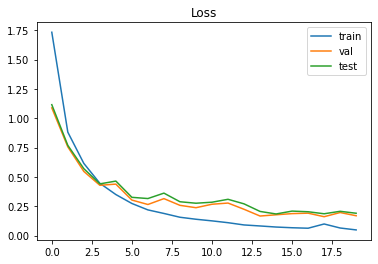

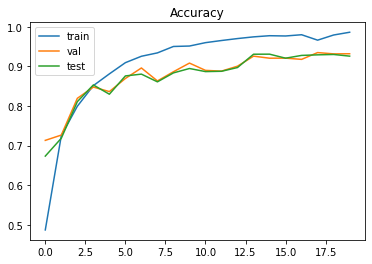

In [152]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

net1 = FirstCNN()
optimizer = optim.SGD(net1.parameters(), lr = 0.005)
criterion = nn.CrossEntropyLoss()


# Define dictionary of loaders
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

results_1 = train(net1, loaders, optimizer, criterion, epochs=20, device=device)

In [153]:
print(results_1)

[0.966501798561151, 0.9351293103448276, 0.9293981481481481]


### 4 Layers

Now we are going to delete the level 5 from the previous model.

In [154]:
class SecondCNN(nn.Module):

  #Constructor
  def __init__(self, in_size=3, out_size=16, use_norm=False):
    # Call parent contructor
    super().__init__()
    self.layers = nn.Sequential(
      # Layer 1
      nn.Conv2d(in_channels=in_size, out_channels=8, kernel_size=3, padding=0, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(8),
      # Layer 2
      nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(16),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 3
      nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(32),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 4
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(64),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )

  # Forward
  def forward(self, x):
    output = self.layers(x)
    return output

In [155]:
net = SecondCNN()

In [156]:
# Get an element from the dataset
test_x, _ = train_dset[0] # each element of the dataset is a couple (image, label)

In [157]:
test_x.size()

torch.Size([3, 32, 32])

In [158]:
test_x = test_x.unsqueeze(dim=0)
test_x.size()

torch.Size([1, 3, 32, 32])

In [159]:
output = net(test_x)
output.shape

torch.Size([1, 64, 3, 3])

In [160]:
out_features = output.size(1)*output.size(2)*output.size(3)
print(out_features)

576


In [161]:
class SecondCNN(nn.Module):

  #Constructor
  def __init__(self, in_size=3, out_size=16, use_norm=False):
    # Call parent contructor
    super().__init__()
    self.layers = nn.Sequential(
      # Layer 1
      nn.Conv2d(in_channels=in_size, out_channels=8, kernel_size=3, padding=0, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(8),
      # Layer 2
      nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(16),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 3
      nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(32),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 4
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(64),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.fc_layers = nn.Sequential(
        nn.Linear(576, 1024), 
        nn.ReLU(),
        nn.Linear(1024, 16)
    )
  # Forward
  def forward(self, x):
    x = self.layers(x)
    x = x.view(x.size(0), -1)
    output = self.fc_layers(x)
    return output

SecondCNN(
  (layers): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (f

train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1: TrL=1.8851, TrA=0.4721, VL=1.3301, VA=0.5809, TeL=1.3250, TeA=0.6082,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2: TrL=1.0501, TrA=0.6967, VL=0.9226, VA=0.7161, TeL=0.9167, TeA=0.7224,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3: TrL=0.7563, TrA=0.7741, VL=0.7425, VA=0.7523, TeL=0.7451, TeA=0.7532,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4: TrL=0.5966, TrA=0.8163, VL=0.6237, VA=0.7773, TeL=0.6397, TeA=0.7861,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5: TrL=0.4767, TrA=0.8561, VL=0.4881, VA=0.8448, TeL=0.5010, TeA=0.8253,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6: TrL=0.4001, TrA=0.8842, VL=0.4494, VA=0.8419, TeL=0.4619, TeA=0.8364,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7: TrL=0.3320, TrA=0.9049, VL=0.4283, VA=0.8542, TeL=0.4237, TeA=0.8544,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8: TrL=0.2848, TrA=0.9184, VL=0.4285, VA=0.8461, TeL=0.4215, TeA=0.8565,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9: TrL=0.2479, TrA=0.9290, VL=0.3343, VA=0.8839, TeL=0.3501, TeA=0.8810,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10: TrL=0.2179, TrA=0.9382, VL=0.3353, VA=0.8679, TeL=0.3312, TeA=0.8794,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11: TrL=0.1881, TrA=0.9483, VL=0.3035, VA=0.8776, TeL=0.3163, TeA=0.8906,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12: TrL=0.1652, TrA=0.9568, VL=0.2882, VA=0.8790, TeL=0.2904, TeA=0.8991,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13: TrL=0.1498, TrA=0.9577, VL=0.2998, VA=0.8901, TeL=0.3162, TeA=0.8827,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14: TrL=0.1315, TrA=0.9672, VL=0.2458, VA=0.9056, TeL=0.2668, TeA=0.9044,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15: TrL=0.1125, TrA=0.9705, VL=0.2371, VA=0.9119, TeL=0.2739, TeA=0.8999,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16: TrL=0.1037, TrA=0.9741, VL=0.2191, VA=0.9211, TeL=0.2479, TeA=0.9077,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17: TrL=0.0933, TrA=0.9795, VL=0.2257, VA=0.9276, TeL=0.2510, TeA=0.9060,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18: TrL=0.0820, TrA=0.9827, VL=0.2156, VA=0.9306, TeL=0.2498, TeA=0.9028,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19: TrL=0.0757, TrA=0.9852, VL=0.2229, VA=0.9197, TeL=0.2621, TeA=0.9014,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20: TrL=0.0708, TrA=0.9845, VL=0.2086, VA=0.9259, TeL=0.2326, TeA=0.9139,


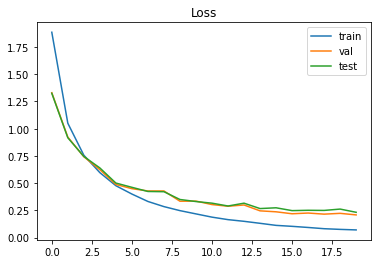

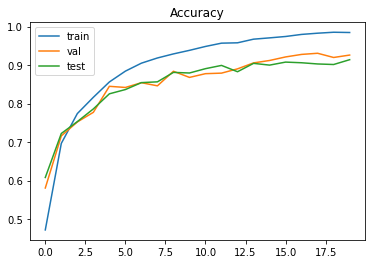

In [162]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

net2 = SecondCNN()
optimizer = optim.SGD(net2.parameters(), lr = 0.005)
criterion = nn.CrossEntropyLoss()


# Define dictionary of loaders
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

results_2 = train(net2, loaders, optimizer, criterion, epochs=20, device=device)

In [163]:
print(results_2)

[0.9844874100719424, 0.9259159482758621, 0.9139178240740741]


## 3 layers 

In [164]:
class ThirdCNN(nn.Module):

  #Constructor
  def __init__(self, in_size=3, out_size=16, use_norm=False):
    # Call parent contructor
    super().__init__()
    self.layers = nn.Sequential(
      # Layer 1
      nn.Conv2d(in_channels=in_size, out_channels=8, kernel_size=3, padding=0, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(8),
      # Layer 2
      nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(16),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 3
      nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(32),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )

  # Forward
  def forward(self, x):
    output = self.layers(x)
    return output

In [165]:
net = ThirdCNN()


In [166]:
# Get an element from the dataset
test_x, _ = train_dset[0] # each element of the dataset is a couple (image, label)

In [167]:
test_x.size()

torch.Size([3, 32, 32])

In [168]:
test_x = test_x.unsqueeze(dim=0)
test_x.size()

torch.Size([1, 3, 32, 32])

In [169]:
output = net(test_x)
output.shape

torch.Size([1, 32, 7, 7])

In [170]:
out_features = output.size(1)*output.size(2)*output.size(3)
print(out_features)

1568


In [171]:
class ThirdCNN(nn.Module):

  #Constructor
  def __init__(self, in_size=3, out_size=16, use_norm=False):
    # Call parent contructor
    super().__init__()
    self.layers = nn.Sequential(
      # Layer 1
      nn.Conv2d(in_channels=in_size, out_channels=8, kernel_size=3, padding=0, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(8),
      # Layer 2
      nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(16),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 3
      nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(32),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.fc_layers = nn.Sequential(
        nn.Linear(1568, 1024), 
        nn.ReLU(),
        nn.Linear(1024, 16)
    )
  # Forward
  def forward(self, x):
    x = self.layers(x)
    x = x.view(x.size(0), -1)
    output = self.fc_layers(x)
    return output

ThirdCNN(
  (layers): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=1568, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=16, bias=True)
  )
)


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1: TrL=1.7164, TrA=0.5022, VL=1.1630, VA=0.6856, TeL=1.1701, TeA=0.6646,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2: TrL=0.8979, TrA=0.7525, VL=0.8403, VA=0.7612, TeL=0.8472, TeA=0.7565,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3: TrL=0.6324, TrA=0.8210, VL=0.6180, VA=0.7926, TeL=0.6281, TeA=0.8060,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4: TrL=0.4884, TrA=0.8647, VL=0.5142, VA=0.8392, TeL=0.5204, TeA=0.8355,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5: TrL=0.3920, TrA=0.8921, VL=0.4832, VA=0.8206, TeL=0.4829, TeA=0.8317,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6: TrL=0.3213, TrA=0.9161, VL=0.3939, VA=0.8870, TeL=0.3983, TeA=0.8777,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7: TrL=0.2711, TrA=0.9310, VL=0.3700, VA=0.8633, TeL=0.3664, TeA=0.8746,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8: TrL=0.2362, TrA=0.9409, VL=0.3223, VA=0.8818, TeL=0.3291, TeA=0.8966,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9: TrL=0.1973, TrA=0.9564, VL=0.3215, VA=0.9068, TeL=0.3254, TeA=0.9155,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10: TrL=0.1716, TrA=0.9591, VL=0.3108, VA=0.8914, TeL=0.3266, TeA=0.8896,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11: TrL=0.1523, TrA=0.9679, VL=0.2474, VA=0.9294, TeL=0.2509, TeA=0.9247,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12: TrL=0.1316, TrA=0.9735, VL=0.2454, VA=0.9054, TeL=0.2396, TeA=0.9234,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13: TrL=0.1183, TrA=0.9777, VL=0.2254, VA=0.9216, TeL=0.2270, TeA=0.9334,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14: TrL=0.1019, TrA=0.9804, VL=0.2241, VA=0.9276, TeL=0.2260, TeA=0.9280,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15: TrL=0.0896, TrA=0.9847, VL=0.2139, VA=0.9228, TeL=0.2091, TeA=0.9272,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16: TrL=0.0825, TrA=0.9870, VL=0.2536, VA=0.8911, TeL=0.2620, TeA=0.8975,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17: TrL=0.0746, TrA=0.9881, VL=0.2135, VA=0.9147, TeL=0.2162, TeA=0.9281,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18: TrL=0.0665, TrA=0.9897, VL=0.1930, VA=0.9244, TeL=0.1889, TeA=0.9288,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19: TrL=0.0578, TrA=0.9921, VL=0.1835, VA=0.9386, TeL=0.2008, TeA=0.9389,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20: TrL=0.0518, TrA=0.9930, VL=0.1912, VA=0.9369, TeL=0.1907, TeA=0.9381,


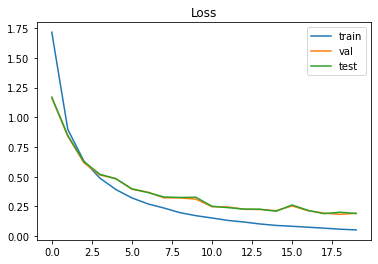

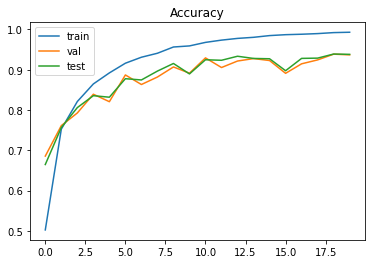

In [172]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

net3 = ThirdCNN()
optimizer = optim.SGD(net3.parameters(), lr = 0.005)
criterion = nn.CrossEntropyLoss()


# Define dictionary of loaders
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

results_3 = train(net3, loaders, optimizer, criterion, epochs=20, device=device)

In [173]:
print(results_3)

[0.9921312949640287, 0.9385775862068966, 0.9389178240740741]


## 2 layers 

In [174]:
class FourthCNN(nn.Module):

  #Constructor
  def __init__(self, in_size=3, out_size=16, use_norm=False):
    # Call parent contructor
    super().__init__()
    self.layers = nn.Sequential(
      # Layer 1
      nn.Conv2d(in_channels=in_size, out_channels=8, kernel_size=3, padding=0, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(8),
      # Layer 2
      nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(16),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )

  # Forward
  def forward(self, x):
    output = self.layers(x)
    return output

In [175]:
net = FourthCNN()

In [176]:
# Get an element from the dataset
test_x, _ = train_dset[0] # each element of the dataset is a couple (image, label)

In [177]:
test_x.size()

torch.Size([3, 32, 32])

In [178]:
test_x = test_x.unsqueeze(dim=0)
test_x.size()

torch.Size([1, 3, 32, 32])

In [179]:
output = net(test_x)
output.shape

torch.Size([1, 16, 15, 15])

In [180]:
out_features = output.size(1)*output.size(2)*output.size(3)
print(out_features)

3600


In [181]:
class FourthCNN(nn.Module):

  #Constructor
  def __init__(self, in_size=3, out_size=16, use_norm=False):
    # Call parent contructor
    super().__init__()
    self.layers = nn.Sequential(
      # Layer 1
      nn.Conv2d(in_channels=in_size, out_channels=8, kernel_size=3, padding=0, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(8),
      # Layer 2
      nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(16),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.fc_layers = nn.Sequential(
        nn.Linear(3600, 1024), 
        nn.ReLU(),
        nn.Linear(1024, 16)
    )
  # Forward
  def forward(self, x):
    x = self.layers(x)
    x = x.view(x.size(0), -1)
    output = self.fc_layers(x)
    return output

FourthCNN(
  (layers): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=3600, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=16, bias=True)
  )
)


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1: TrL=1.4788, TrA=0.5998, VL=0.9119, VA=0.7340, TeL=0.9100, TeA=0.7457,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2: TrL=0.7014, TrA=0.8076, VL=0.6140, VA=0.8034, TeL=0.5986, TeA=0.8168,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3: TrL=0.4894, TrA=0.8613, VL=0.4901, VA=0.8443, TeL=0.4736, TeA=0.8479,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4: TrL=0.3803, TrA=0.8932, VL=0.4876, VA=0.8114, TeL=0.4644, TeA=0.8236,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5: TrL=0.3097, TrA=0.9116, VL=0.3659, VA=0.8634, TeL=0.3646, TeA=0.8669,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6: TrL=0.2642, TrA=0.9245, VL=0.3271, VA=0.9022, TeL=0.3284, TeA=0.8927,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7: TrL=0.2235, TrA=0.9391, VL=0.2696, VA=0.9244, TeL=0.2836, TeA=0.9036,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8: TrL=0.1901, TrA=0.9510, VL=0.2790, VA=0.9039, TeL=0.2780, TeA=0.8936,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9: TrL=0.1668, TrA=0.9600, VL=0.2415, VA=0.9147, TeL=0.2398, TeA=0.9061,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10: TrL=0.1463, TrA=0.9622, VL=0.2126, VA=0.9276, TeL=0.2245, TeA=0.9163,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11: TrL=0.1311, TrA=0.9710, VL=0.2041, VA=0.9356, TeL=0.2254, TeA=0.9255,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12: TrL=0.1175, TrA=0.9730, VL=0.1912, VA=0.9464, TeL=0.2052, TeA=0.9311,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13: TrL=0.1055, TrA=0.9768, VL=0.1869, VA=0.9353, TeL=0.2004, TeA=0.9256,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14: TrL=0.0954, TrA=0.9807, VL=0.1893, VA=0.9320, TeL=0.1970, TeA=0.9241,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15: TrL=0.0865, TrA=0.9831, VL=0.1675, VA=0.9526, TeL=0.1960, TeA=0.9302,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16: TrL=0.0780, TrA=0.9852, VL=0.1705, VA=0.9511, TeL=0.1912, TeA=0.9278,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17: TrL=0.0715, TrA=0.9861, VL=0.1458, VA=0.9542, TeL=0.1709, TeA=0.9405,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18: TrL=0.0643, TrA=0.9894, VL=0.1453, VA=0.9577, TeL=0.1683, TeA=0.9396,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19: TrL=0.0623, TrA=0.9874, VL=0.1400, VA=0.9637, TeL=0.1582, TeA=0.9484,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20: TrL=0.0539, TrA=0.9903, VL=0.1430, VA=0.9544, TeL=0.1647, TeA=0.9435,


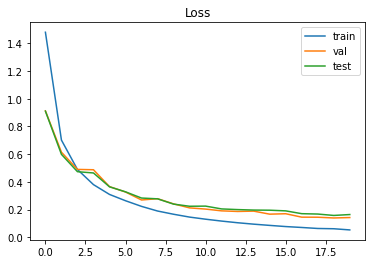

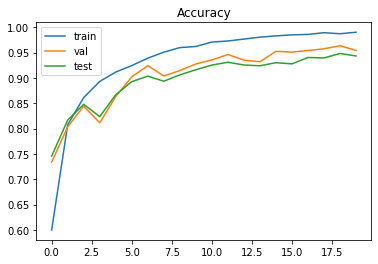

In [182]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

net4 = FourthCNN()
optimizer = optim.SGD(net4.parameters(), lr = 0.005)
criterion = nn.CrossEntropyLoss()


# Define dictionary of loaders
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

results_4 = train(net4, loaders, optimizer, criterion, epochs=20, device=device)

In [183]:
print(results_4)

[0.987410071942446, 0.963739224137931, 0.9484375]


## 1 layer 

In [184]:
class FifthCNN(nn.Module):

  #Constructor
  def __init__(self, in_size=3, out_size=16, use_norm=False):
    # Call parent contructor
    super().__init__()
    self.layers = nn.Sequential(
      # Layer 1
      nn.Conv2d(in_channels=in_size, out_channels=8, kernel_size=3, padding=0, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(8)
    )

  # Forward
  def forward(self, x):
    output = self.layers(x)
    return output

In [185]:
net = FifthCNN()

In [186]:
# Get an element from the dataset
test_x, _ = train_dset[0] # each element of the dataset is a couple (image, label)

In [187]:
test_x.size()

torch.Size([3, 32, 32])

In [188]:
test_x = test_x.unsqueeze(dim=0)
test_x.size()

torch.Size([1, 3, 32, 32])

In [189]:
output = net(test_x)
output.shape

torch.Size([1, 8, 30, 30])

In [190]:
out_features = output.size(1)*output.size(2)*output.size(3)
print(out_features)

7200


In [191]:
class FifthCNN(nn.Module):

  #Constructor
  def __init__(self, in_size=3, out_size=16, use_norm=False):
    # Call parent contructor
    super().__init__()
    self.layers = nn.Sequential(
      # Layer 1
      nn.Conv2d(in_channels=in_size, out_channels=8, kernel_size=3, padding=0, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(8)
    )
    self.fc_layers = nn.Sequential(
        nn.Linear(7200, 1024), 
        nn.ReLU(),
        nn.Linear(1024, 16)
    )
  # Forward
  def forward(self, x):
    x = self.layers(x)
    x = x.view(x.size(0), -1)
    output = self.fc_layers(x)
    return output

FifthCNN(
  (layers): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=7200, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=16, bias=True)
  )
)


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1: TrL=1.5262, TrA=0.5922, VL=0.9736, VA=0.7157, TeL=0.9533, TeA=0.7288,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2: TrL=0.7515, TrA=0.7880, VL=0.6750, VA=0.7878, TeL=0.6596, TeA=0.7899,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3: TrL=0.5438, TrA=0.8417, VL=0.5154, VA=0.8331, TeL=0.5119, TeA=0.8275,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4: TrL=0.4309, TrA=0.8732, VL=0.4512, VA=0.8634, TeL=0.4446, TeA=0.8675,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5: TrL=0.3574, TrA=0.8961, VL=0.4107, VA=0.8553, TeL=0.3935, TeA=0.8697,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6: TrL=0.3009, TrA=0.9112, VL=0.3552, VA=0.8943, TeL=0.3561, TeA=0.8911,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7: TrL=0.2586, TrA=0.9283, VL=0.3183, VA=0.8947, TeL=0.3316, TeA=0.8800,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8: TrL=0.2311, TrA=0.9362, VL=0.2962, VA=0.8900, TeL=0.2972, TeA=0.8864,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9: TrL=0.2053, TrA=0.9402, VL=0.2981, VA=0.8933, TeL=0.3038, TeA=0.8903,


train:   0%|          | 0/139 [00:00<?, ?it/s]

val:   0%|          | 0/20 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10: TrL=0.1839, TrA=0.9472, VL=0.2476, VA=0.9244, TeL=0.2520, TeA=0.9099,


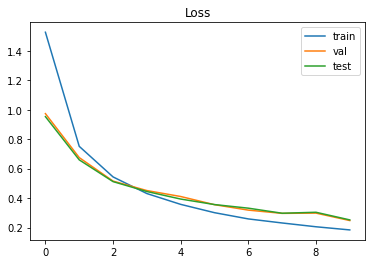

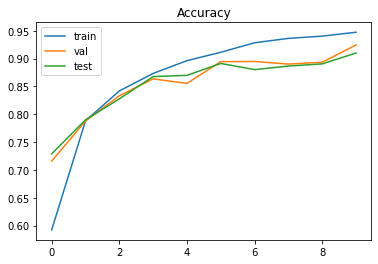

In [192]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

net5 = FifthCNN()
optimizer = optim.SGD(net5.parameters(), lr = 0.005)
criterion = nn.CrossEntropyLoss()


# Define dictionary of loaders
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

results_5 = train(net5, loaders, optimizer, criterion, epochs=10, device=device)

In [193]:
print(results_5)

[0.9471672661870504, 0.9243534482758621, 0.9098668981481481]


In [194]:
percentage1 = [str(round(num * 100, 2))+"%" for num in results_1]
percentage2 = [str(round(num * 100, 2))+"%" for num in results_2]
percentage3 = [str(round(num * 100, 2))+"%" for num in results_3]
percentage4 = [str(round(num * 100, 2))+"%" for num in results_4]
percentage5 = [str(round(num * 100, 2))+"%" for num in results_5]


In [195]:
print(percentage1)

['96.65%', '93.51%', '92.94%']


In [196]:
results = [percentage1, percentage2, percentage3, percentage4, percentage5]
models = ["Five layers", "Four layers", "Three layers", "Two Layers", "One Layer"]
df = pd.DataFrame(results, columns =['Train', 'Validation', 'Test'], index = models, dtype = str)
df

Train Validation    Test
Five layers   96.65%     93.51%  92.94%
Four layers   98.45%     92.59%  91.39%
Three layers  99.21%     93.86%  93.89%
Two Layers    98.74%     96.37%  94.84%
One Layer     94.72%     92.44%  90.99%

In [197]:
#Choose the best CNN
resultlist = []
for result in (results_1, results_2, results_3, results_4, results_5):
  resultlist.append(result[2])
print(resultlist)
if max(resultlist) == results_1[2]:
  net = net1
  print("Best Network: 5 layer CNN")
elif max(resultlist) == results_2[2]:
  net = net2
  print("Best Network: 4 layers CNN")
elif max(resultlist) == results_3[2]:
  net = net3
  print("Best Network: 3 layers CNN")
elif max(resultlist) == results_4[2]:
  net = net4
  print("Best Network: 2 layers CNN")
elif max(resultlist) == results_5[2]:
  net = net5
  print("Best Network: 1 layers CNN")

[0.9293981481481481, 0.9139178240740741, 0.9389178240740741, 0.9484375, 0.9098668981481481]
Best Network: 2 layers CNN


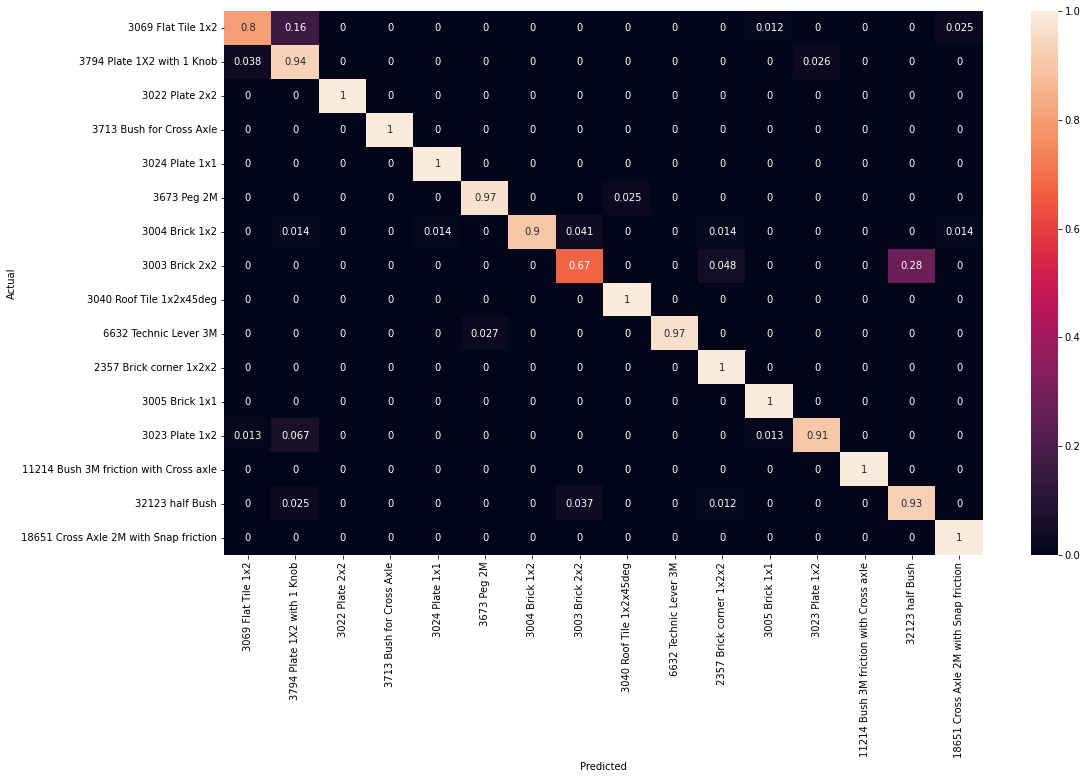

In [203]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
  inputs, labels = inputs.cuda(), labels.cuda()
  output = net(inputs) # Feed Network
  output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
  y_pred.extend(output) # Save Prediction
  
  labels = labels.data.cpu().numpy()
  y_true.extend(labels) # Save Truth

# constant for classes
classes = os.listdir(dest_dir)

# Build confusion matrix
cm = confusion_matrix(y_true, y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(17,10))
sns.heatmap(cmn, annot=True, xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)